# B-KinD Demo Notebook

This notebook will provide demo code and data for running B-KinD, keypoint discovery in behavioral videos without human annotations. No other setups are needed. If you would like help running B-KinD on your videos, please fill out this [form](https://forms.gle/k5gwNxws8xMEEzUe6).

See more information on our keypoint discovery work below!

Project Website: https://sites.google.com/view/b-kind

Github page: https://github.com/neuroethology/BKinD

CVPR 2022 Paper: https://openaccess.thecvf.com/content/CVPR2022/papers/Sun_Self-Supervised_Keypoint_Discovery_in_Behavioral_Videos_CVPR_2022_paper.pdf

#Enable GPU Runtime (Free on Colab!)

You can switch your runtime to GPU as follows:

*    Go to "Runtime" on the menu bar above, and click on "Change runtime type".

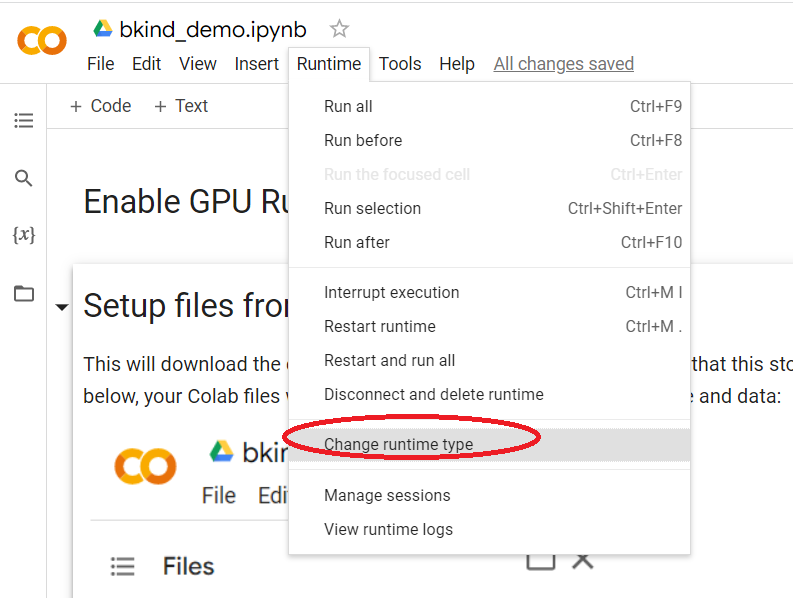

*     In the popup window, first select GPU as the Hardware Accelerator, then click Save.

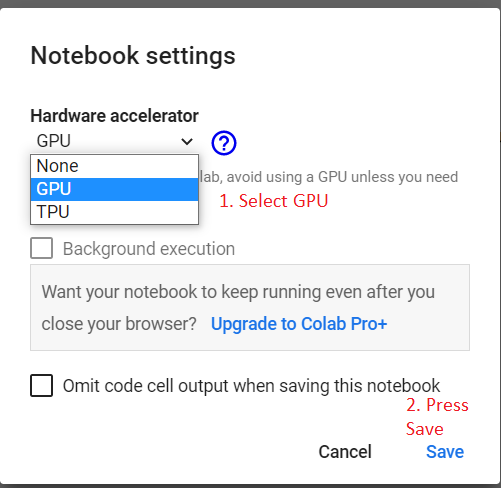

# Download demo code and data

This will download the demo code and data into Colab storage (note that this storage is temporary for a Colab session). After running the code below, your Colab files will look like the below with BKinD_demo code and data:

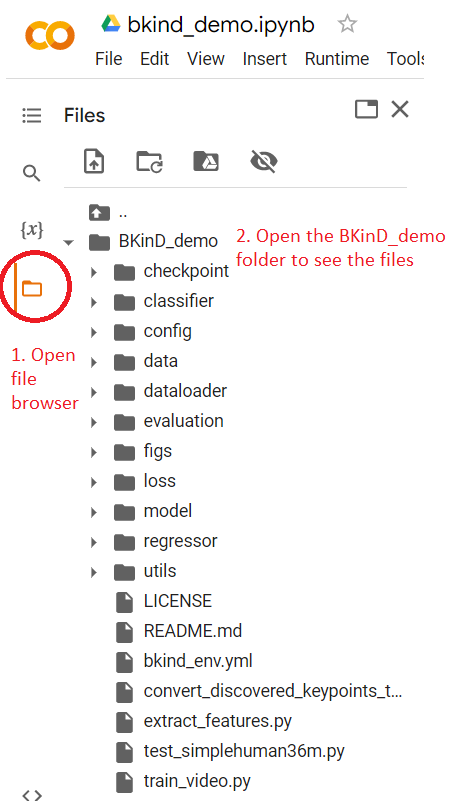

*Optional*: If you would like to keep the run results permanently, you would need to connect Colab to your Google Drive: (1) download the code and data directly from https://drive.google.com/file/d/1NLrJcRasy-6LRY19yI3NPuT0LZylyQCn/view?usp=sharing, (2) unzip locally, (3) upload to your Google Drive so that you have edit permission of the folder, (4) mount Google Drive to Colab with `from google.colab import drive` and `drive.mount('/content/drive/')`.


In [6]:
# https://drive.google.com/file/d/1NLrJcRasy-6LRY19yI3NPuT0LZylyQCn/view?usp=sharing
!gdown 1NLrJcRasy-6LRY19yI3NPuT0LZylyQCn -O bkind_demo.zip
!unzip -q bkind_demo.zip 
%cd BKinD_demo

Downloading...
From: https://drive.google.com/uc?id=1NLrJcRasy-6LRY19yI3NPuT0LZylyQCn
To: /content/BKinD_demo/bkind_demo.zip
100% 1.03G/1.03G [00:04<00:00, 249MB/s]
/content/BKinD_demo/BKinD_demo


In [7]:
!pip install piq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Run training

We show a demo of CalMS21_demo.yaml which loads a pre-trained checkpoint and trains for 2 epochs on the mini CalMS21 dataset.

More information on the full CalMS21 dataset here: https://arxiv.org/pdf/2104.02710.pdf.

In [8]:
# Run a mini-version of our CalMS21 experiments

!python train_video.py --config config/CalMS21_demo.yaml 

train_video.py:29: UserWarning: You have chosen a specific GPU. This will completely disable data parallelism.
  warnings.warn('You have chosen a specific GPU. This will completely '
Use GPU: 0 for training
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100% 548M/548M [00:08<00:00, 67.8MB/s]
=> loading checkpoint 'checkpoint/CalMS21/checkpoint.pth.tar'
=> loaded checkpoint 'checkpoint/CalMS21/checkpoint.pth.tar' (epoch 14)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-package

You should be able to see results inside `BKinD_demo/checkpoint/CalMS21_demo/epoch_14` and `epoch_15`. Double click on the image names to see visualizations.

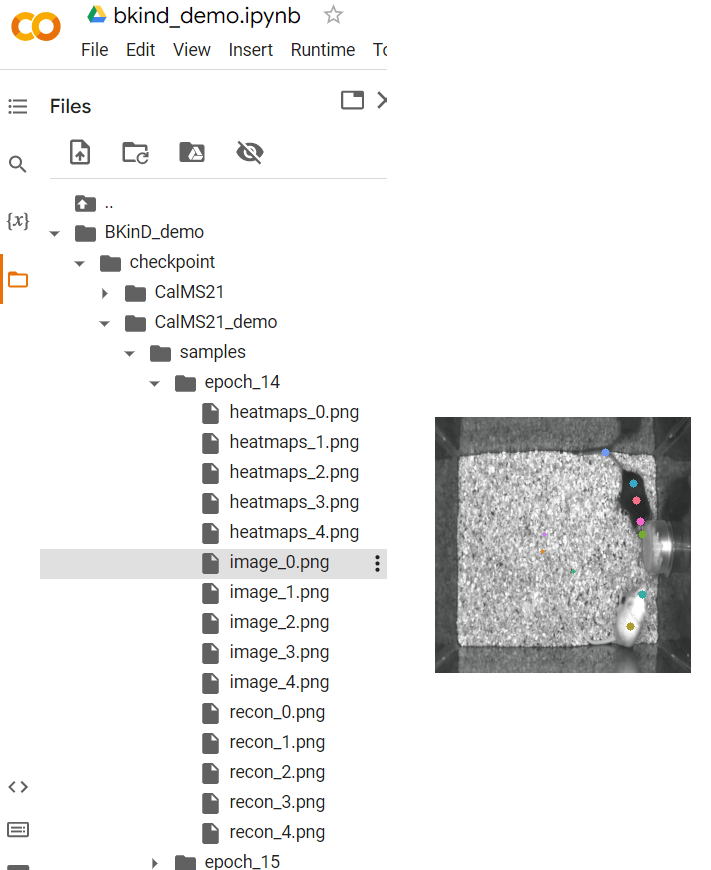

# Result Visualization
Once you are done with training a B-KinD model, you can run a demo on sample images. If you changed the default input setting (e.g., `nKps`, `gpu`, and `resume`) please modify the input parameters before you run a model. Images with discovered keypoints will be saved in the `sample_images` directory.

In [3]:
# Load images and run inference
# Add more images in the samples directory if you want to test BKinD on different samples.
import torch
import torchvision
import torchvision.transforms as transforms

from model.unsupervised_model_multi_agents import Model as BKinD
from model.kpt_detector import Model
# from google.colab.patches import cv2_imshow
import cv2

import cv2
from PIL import Image
from utils import visualize_with_circles

import numpy as np
import os

## Input parameters #################################
nKps = 5
gpu = 0  # None if gpu is not available
resume = 'checkpoint/custom_dataset/checkpoint.pth.tar'
sample_path = '../4rats/images/test'
image_size = 256
#####################################################

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean=mean, std=std)
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    normalize,])

## Load a model
model = Model(nKps)
if os.path.isfile(resume):
  if gpu is not None:
    model = model.cuda(gpu)
    loc = 'cuda:{}'.format(gpu)
    checkpoint = torch.load(resume, map_location=loc)
  else:
    checkpoint = torch.load(resume)

  bkind_model = BKinD(nKps)

  bkind_model.load_state_dict(checkpoint['state_dict'])
  bkind_model_dict = bkind_model.state_dict()

  model_dict = model.state_dict()
  pretrained_dict = {k: v for k, v in bkind_model_dict.items() if k in model_dict}
  model_dict.update(pretrained_dict)
  model.load_state_dict(model_dict)

  print("=> loaded checkpoint '{}' (epoch {})"
        .format(resume, checkpoint['epoch']))
else:
  print("=> no checkpoint found at '{}'".format(resume))

## Inference on sample images
sample_files = sorted(os.listdir(sample_path))
for i in range(len(sample_files)):
  if 'output' not in sample_files[i]:
    with open(os.path.join(sample_path, sample_files[i]), 'rb') as f:
      im = Image.open(f)
      im = im.convert('RGB')

    im = torchvision.transforms.Resize((image_size, image_size))(im)
    im = transform(im)
    im = im.unsqueeze(0).cuda(gpu, non_blocking=True)

    output = model(im)

    pred_kps = torch.stack((output[0][0], output[0][1]), dim=2)
    pred_kps = pred_kps.data.cpu().numpy()

    im_with_kps = visualize_with_circles(im[0].data.cpu().numpy(), pred_kps[0]+1, 
                                        output[5][0], mean=mean, std=std)
    im_with_kps = im_with_kps.astype('uint8')
    im_with_kps = cv2.cvtColor(im_with_kps, cv2.COLOR_RGB2BGR)
    cv2.imwrite(os.path.join('../4rats/images/results2', 'output_'+str(i+1)+'.png'), im_with_kps)

    # cv2.imshow(im_with_kps)

print("==> Output images saved in \'sample_images\' directory")

=> loaded checkpoint 'checkpoint/custom_dataset/checkpoint.pth.tar' (epoch 3)


NotImplementedError: Got 5D input, but bilinear mode needs 4D input

# Custom Datasets

In order to run B-KinD and extract keypoints on your own data, you would need:

*    `data`: the data itself as image sequences with `train` and `val` folders inside the `data` folder.
*    `config`: update the `custom_dataset.yaml` config file to track your desired number of keypoints `nkpts`, with `frame_gap` depending on your video frame rate (in our experiments we use the number of frames corresponding to around 0.2 seconds)

Please see our code https://github.com/neuroethology/BKinD for more information!

In [ ]:
# !python train_video.py --config config/custom_dataset.yaml 